In [22]:
import pandas
import numpy
from datetime import datetime, timedelta
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from StockPriceForModel import StockPriceForModel


## Getting stock data from StockPriceForModel
We can choose any ticker and the time period (e.g. 2,3,5 or 10 years) to train and predict data. The code will grasp data from today to the time period you choose.

In this code, we choose APPLE stock with time period = 10 years.

Each record in the price_features will contains the original stock trading data and the price label (label_price) which is the close price of the next day as the class to predict.

We also add numbers of technical indicators which captures all historical data and the historical stock movement's important information.

Here is the list of technical indicators we have added into our stock dataset:

middle = (close + high + low) / 3
SMA: simple moving average
EMA: exponential moving average
MSTD: moving standard deviation
MVAR: moving variance
RSV: raw stochastic value
RSI: relative strength index
KDJ: Stochastic oscillator
Bolling: including upper band and lower band.
MACD: moving average convergence divergence. Including signal and histogram. (see note)
CR:
WR: Williams Overbought/Oversold index
CCI: Commodity Channel Index
TR: true range
ATR: average true range
line cross check, cross up or cross down.
DMA: Different of Moving Average (10, 50)
DMI: Directional Moving Index, including
+DI: Positive Directional Indicator
-DI: Negative Directional Indicator
ADX: Average Directional Movement Index
ADXR: Smoothed Moving Average of ADX
TRIX: Triple Exponential Moving Average
VR: Volatility Volume Ratio


In [23]:
ticker = 'AAPL'
to_date = datetime.strftime(datetime.today() - timedelta(days=1), '%Y-%m-%d')
from_date = datetime.strftime(datetime.today() - timedelta(days=10*365), '%Y-%m-%d')
appl = StockPriceForModel(ticker, from_date, to_date, 2, 15)
dataframe = appl.price_features
dataframe = dataframe.dropna()

C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\stockstats.py:189: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  center=False, window=shifts).apply(np.count_nonzero)
C:\Users\dt85289\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will

## Plot the stock's close price
In this block, we plot the close price of the stock comparing with the simple movement average of 50, 200 days.
You can the trend for short term and long term price movement. 

['adj_close' 'close' 'high' 'label_price' 'low' 'open' 'volume'
 'volume_delta' 'open_-2_r' 'middle' 'cr' 'cr-ma1' 'cr-ma2' 'cr-ma3'
 'cr-ma1_20_c' 'cr-ma2_xu_cr-ma1_20_c' 'volume_-3_s' 'volume_-1_s'
 'volume_2_s' 'volume_-3,2,-1_max' 'volume_-2_s' 'volume_0_s' 'volume_1_s'
 'volume_-3~1_min' 'rsv_9' 'kdjk_9' 'kdjk' 'kdjd_9' 'kdjd' 'kdjj_9' 'kdjj'
 'close_2_sma' 'close_5_sma' 'close_20_sma' 'close_50_sma' 'close_200_sma'
 'close_-1_s' 'close_-1_d' 'rs_6' 'rsi_6' 'rs_12' 'rsi_12' 'wr_10' 'wr_6'
 'middle_14_sma' 'cci' 'middle_20_sma' 'cci_20' 'tr' 'atr' 'close_10_sma'
 'dma' 'high_delta' 'um' 'low_delta' 'dm' 'pdm' 'pdm_14_ema' 'pdm_14'
 'atr_14' 'pdi_14' 'pdi' 'mdm' 'mdm_14_ema' 'mdm_14' 'mdi_14' 'mdi'
 'dx_14' 'dx' 'dx_6_ema' 'adx' 'adx_6_ema' 'adxr' 'trix' 'trix_9_sma'
 'change' 'vr' 'vr_6_sma' 'close_12_ema' 'close_26_ema' 'macd' 'macds'
 'macdh' 'close_20_mstd' 'boll' 'boll_ub' 'boll_lb']


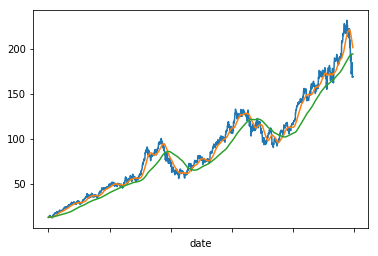

In [24]:
print(dataframe.columns.get_values())
sp_close_series = dataframe.close
sp_close_series.plot()
sp_sma_series_50 = dataframe.close_50_sma  
sp_sma_series_50.plot()
sp_sma_series_200 = dataframe.close_200_sma  
sp_sma_series_200.plot()

## Model
We use a simple linear regression as the first model for our prediction.
We also use pipline to do some feature tasks:
+ Impute missing values using the mean
+ Transform features to quadratic
+ Fit a linear regression
The returned performances are quit good with R^2 in range of [0.5,1]

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer 
from sklearn import model_selection

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

X = dataframe.loc[:, dataframe.columns != 'label_price']
y = dataframe.loc[:,'label_price']
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("MAE: ", results.mean(), results.std())
scoring = 'r2'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("R^2:", results.mean(), results.std())

MAE:  -2.2216456586842286 0.8838531561770991
R^2: 0.7360911734764923 0.3442865172479354
